<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General" data-toc-modified-id="General-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General</a></span></li><li><span><a href="#Metro" data-toc-modified-id="Metro-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metro</a></span></li><li><span><a href="#Metrobús" data-toc-modified-id="Metrobús-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metrobús</a></span></li><li><span><a href="#ECOBICI" data-toc-modified-id="ECOBICI-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ECOBICI</a></span></li></ul></div>

In [1]:
import requests
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

def momento_dia(hora: int)-> str:
    if hora<=11:
        return "Mañana"
    elif hora<=18:
        return "Tarde"
    else:
        return "Noche"

headers = {
    'cache-control': 'no-cache',
    'content-type': 'application/json',
    'origin': 'https://app.semovi.cdmx.gob.mx',
    'pragma': 'no-cache',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36',
}

json_data = {
    'serie': '#SERIE',
    'anio': '2024',
    'operacion': 'todas',
}

days_of_week = {
    "Monday": "Lunes",
    "Tuesday": "Martes",
    "Wednesday": "Miércoles",
    "Thursday": "Jueves",
    "Friday": "Viernes",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}

response = requests.post(
    'https://app.semovi.cdmx.gob.mx/micrositio/291-trazabilidad_tarjetas.php',
    headers=headers,
    json=json_data,
)
df = pd.DataFrame(response.json()["data"])
df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True)
df["saldo_final"] = pd.to_numeric(df["saldo_final"])
df["monto"] = pd.to_numeric(df["monto"])
df["dia_semana"] = df["fecha"].dt.day_name().map(days_of_week)
df["momento_dia"] = df["fecha"].dt.hour.apply(momento_dia)
df["day_of_week"] = df["fecha"].dt.day_of_week
orden_dias = list(days_of_week.values())
orden_momento = ["Mañana", "Tarde", "Noche"]

df.head()

,numero,num_serie,organismo,linea,estacion,operacion,monto,saldo_final,fecha,dia_semana,momento_dia,day_of_week
0,1,00000000C3325002,METROBÚS,01,HAMBURGO,03-VALIDACION,6.0,2.0,2024-07-27 17:08:04,Sábado,Tarde,5
1,2,00000000C3325002,STC,7,AUDITORIO,03-VALIDACION,5.0,8.0,2024-07-26 22:06:32,Viernes,Noche,4
2,3,00000000C3325002,STC,7,SAN PEDRO DE LOS PINOS,03-VALIDACION,5.0,13.0,2024-07-26 18:49:12,Viernes,Tarde,4
3,4,00000000C3325002,STC,2,NATIVITAS,03-VALIDACION,5.0,18.0,2024-07-25 21:19:25,Jueves,Noche,3
4,5,00000000C3325002,STC,2,GENERAL ANAYA,03-VALIDACION,5.0,23.0,2024-07-23 21:56:36,Martes,Noche,1


In [2]:
with open("datos/data.json", "w") as f:
    f.write(response.text)

In [3]:
df.shape

(159, 12)

In [4]:
df["organismo"].unique()

array(['METROBÚS', 'STC', 'ORT', 'ECOBICI'], dtype=object)

In [5]:
df["operacion"].unique()

array(['03-VALIDACION', '00-RECARGA', '71-FIN DE VIAJE',
       '70-INICIO DE VIAJE', '07-TRANSBORDO'], dtype=object)

# General

Total de viajes registrados: 159


<AxesSubplot:title={'center':'Viajes por sistema'}, ylabel='organismo'>

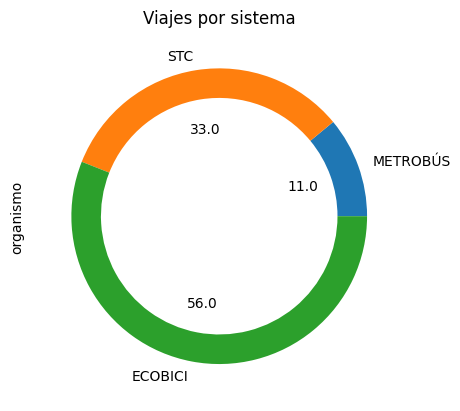

In [6]:
today = datetime.datetime.now()
viajes = df.query("operacion!=['71-FIN DE VIAJE', '00-RECARGA'] & fecha<=@today")
print("Total de viajes registrados:", df.shape[0])
viajes["organismo"].value_counts()[::-1].plot.pie(title="Viajes por sistema", autopct='%.1f',
                   wedgeprops={'width': 0.2})

<AxesSubplot:title={'center':'Viajes por sistema, mensual'}, xlabel='fecha'>

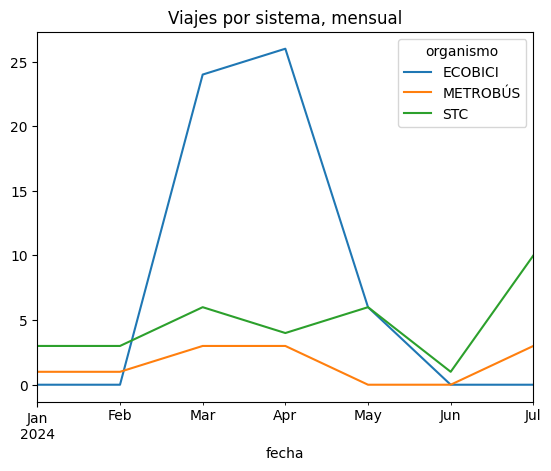

In [7]:
modalidad_tiempo = viajes.groupby([pd.Grouper(key="fecha", freq="1M"), "organismo"])["numero"].count()\
    .unstack()\
    .fillna(0)
modalidad_tiempo.plot(title="Viajes por sistema, mensual")

<AxesSubplot:title={'center':'Viajes totales, por sistema, mensual'}, xlabel='fecha'>

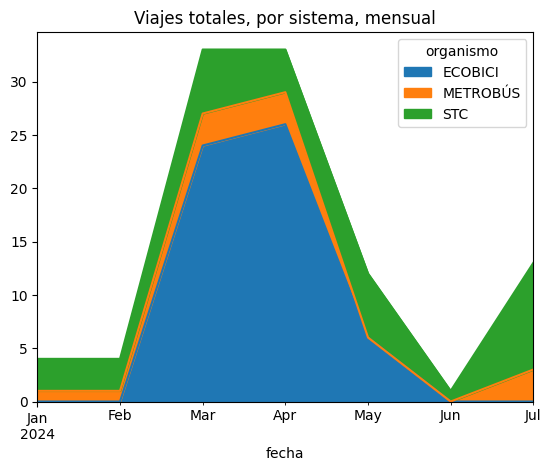

In [8]:
modalidad_tiempo.plot.area(title="Viajes totales, por sistema, mensual")

<AxesSubplot:title={'center':'Viajes por sistema y día de la semana'}, xlabel='dia_semana'>

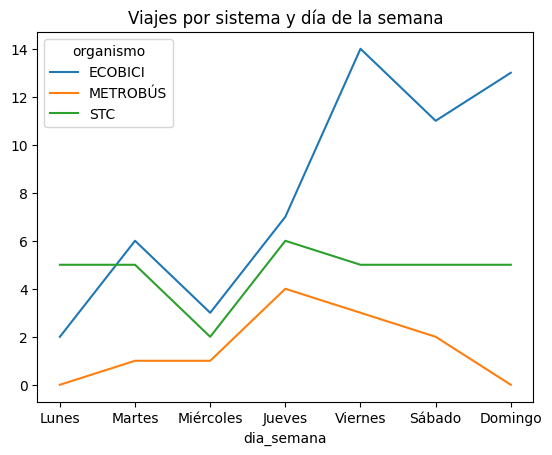

In [9]:
pd.crosstab(viajes["dia_semana"], viajes["organismo"]).loc[orden_dias].plot(
    title="Viajes por sistema y día de la semana"
)

<AxesSubplot:title={'center':'Viajes por sistema y momento de la semana'}, xlabel='organismo'>

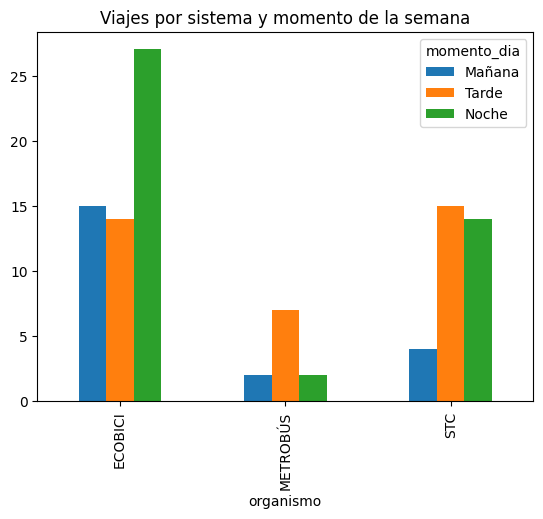

In [10]:
pd.crosstab(viajes["organismo"], viajes["momento_dia"]).loc[:, orden_momento].plot.bar(
    title="Viajes por sistema y momento de la semana"
)

Text(0.5, 1.0, 'Viajes por día de la semana y momento')

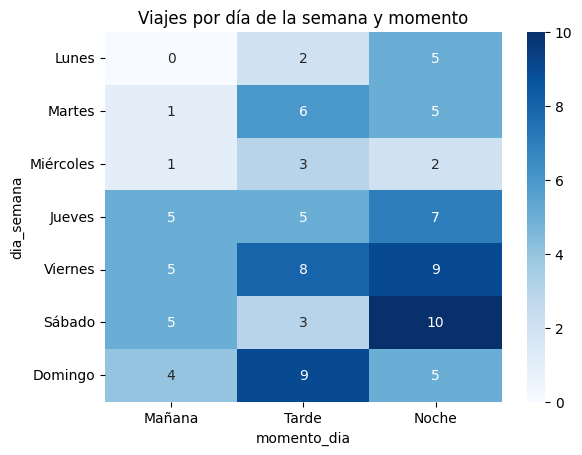

In [11]:
viajes_dia = pd.crosstab(viajes["dia_semana"], viajes["momento_dia"]).loc[orden_dias, orden_momento]
ax = sns.heatmap(viajes_dia, annot=True, cmap="Blues")
ax.set_title("Viajes por día de la semana y momento")

Text(0.5, 1.1, 'Viajes por sistema, según día de la semana y momento del día')

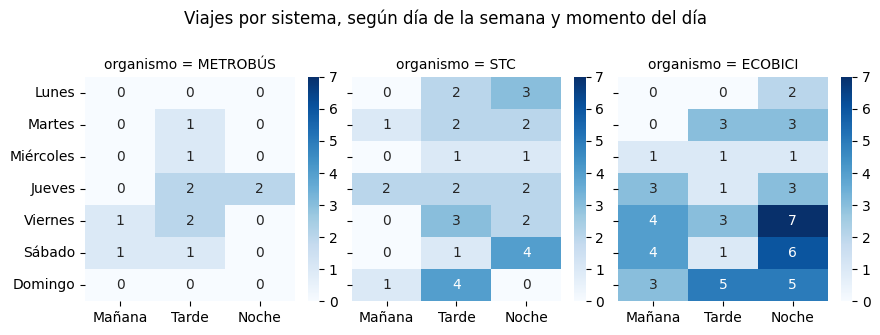

In [12]:
max_value_heatmap_momento_dia = viajes.groupby(["dia_semana", "momento_dia", "organismo"])['numero'].count().max()
def heatmap_momento_dia(data, **kws):
    dia_semana = (pd.DataFrame(index=orden_dias, columns=orden_momento).fillna(0)\
        + pd.crosstab(data["dia_semana"], data["momento_dia"]))\
        .loc[orden_dias, orden_momento]\
        .fillna(0)
    ax = plt.gca()
    sns.heatmap(dia_semana, annot=True, cmap="Blues", ax=ax, vmin=0, vmax=max_value_heatmap_momento_dia, **kws)

g = sns.FacetGrid(viajes, col="organismo", margin_titles=True, despine=False, sharey=True)
g.figure.subplots_adjust(wspace=0, hspace=0)
g.map_dataframe(heatmap_momento_dia)
g.figure.suptitle("Viajes por sistema, según día de la semana y momento del día", y=1.1)

<AxesSubplot:title={'center':'Saldo de tarjeta MI'}, xlabel='fecha'>

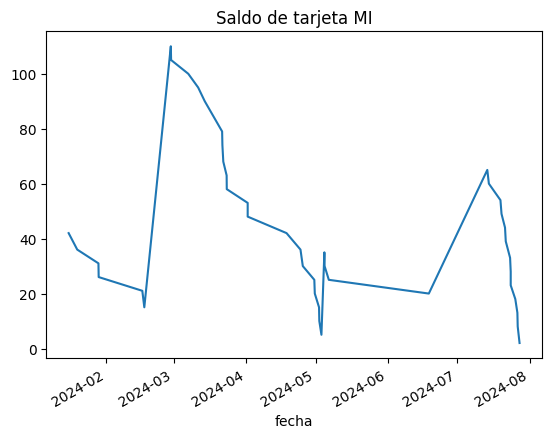

In [13]:
viajes.query("monto!=0").sort_values(["fecha"])\
    .set_index("fecha")["saldo_final"]\
    .plot(title="Saldo de tarjeta MI")

In [14]:
print("Total gastado en viajes:", viajes["monto"].sum())

Total gastado en viajes: 225.0


<AxesSubplot:title={'center':'Gasto acumulado por sistema de transporte'}, xlabel='fecha'>

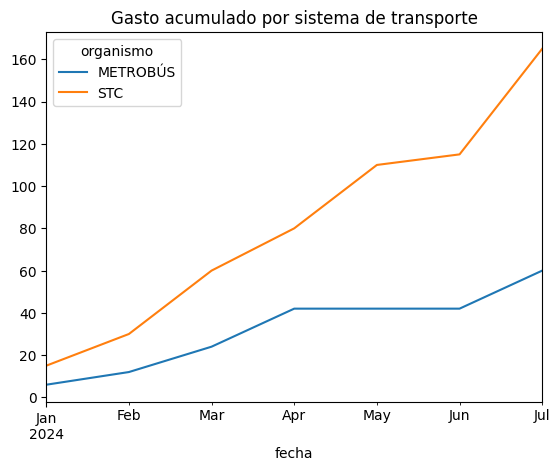

In [15]:
viajes.query("organismo!='ECOBICI'").groupby([pd.Grouper(key="fecha", freq="1M"), "organismo"])["monto"].sum()\
    .unstack()\
    .cumsum()\
    .fillna(method='ffill')\
    .plot(title="Gasto acumulado por sistema de transporte")

# Metro

In [16]:
metro = viajes.query("organismo=='STC'")
metro.head()

,numero,num_serie,organismo,linea,estacion,operacion,monto,saldo_final,fecha,dia_semana,momento_dia,day_of_week
1,2,00000000C3325002,STC,7,AUDITORIO,03-VALIDACION,5.0,8.0,2024-07-26 22:06:32,Viernes,Noche,4
2,3,00000000C3325002,STC,7,SAN PEDRO DE LOS PINOS,03-VALIDACION,5.0,13.0,2024-07-26 18:49:12,Viernes,Tarde,4
3,4,00000000C3325002,STC,2,NATIVITAS,03-VALIDACION,5.0,18.0,2024-07-25 21:19:25,Jueves,Noche,3
4,5,00000000C3325002,STC,2,GENERAL ANAYA,03-VALIDACION,5.0,23.0,2024-07-23 21:56:36,Martes,Noche,1
5,6,00000000C3325002,STC,2,GENERAL ANAYA,03-VALIDACION,5.0,28.0,2024-07-23 21:56:32,Martes,Noche,1


In [17]:
print("Total de viajes en metro:", metro.shape[0])

Total de viajes en metro: 33


<AxesSubplot:title={'center':'Viajes por línea del metro'}>

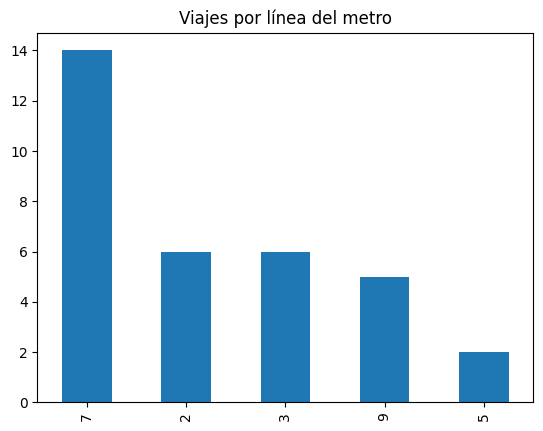

In [18]:
metro["linea"].value_counts().plot.bar(title="Viajes por línea del metro")

<AxesSubplot:title={'center':'Top 10 estaciones de metro más usadas'}>

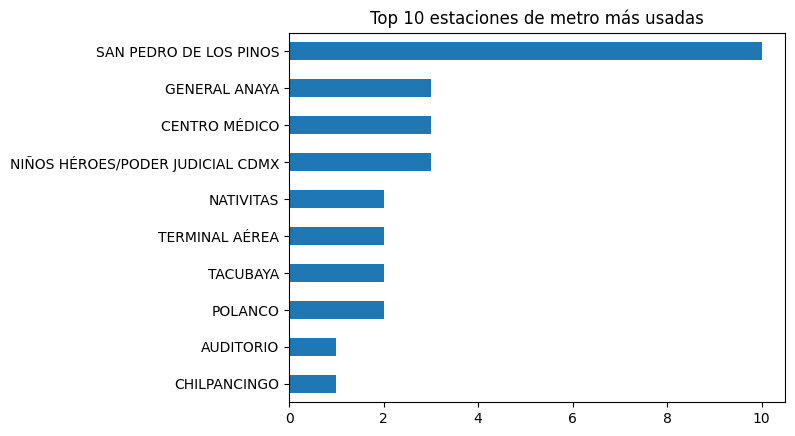

In [19]:
top_n_estaciones = 10
metro["estacion"].value_counts().head(top_n_estaciones)[::-1]\
    .plot.barh(title=f"Top {top_n_estaciones} estaciones de metro más usadas")

<AxesSubplot:title={'center':'Viajes en metro, por semana'}, xlabel='fecha'>

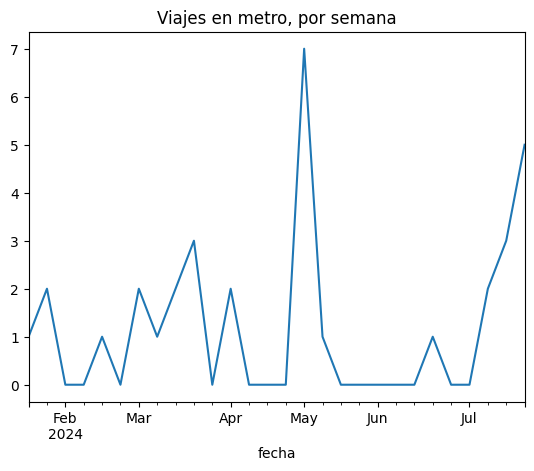

In [20]:
metro.groupby(pd.Grouper(key='fecha', freq="1W"))\
    ["linea"].count().plot(title="Viajes en metro, por semana")

In [21]:
import geopandas as gpd
import folium
# Leer el archivo SHP con GeoPandas
shp_estaciones = 'datos/stcmetro_shp/STC_Metro_estaciones_utm14n.shp'
shp_lineas = 'datos/stcmetro_shp/STC_Metro_lineas_utm14n.shp'
metro_line_colors = ['#F28D1A', '#0A4B3D', '#C6A329', '#C73A43', '#D53B44', '#CB8D43', '#976EAE', '#E75383', '#AD50B8', '#F28C23', '#A29D93', '#91C2A9']

gdf_est = gpd.read_file(shp_estaciones)
lineas = gpd.read_file(shp_lineas)
lineas["style"] = [{"weight": 4, "color": color.lower()} for color in metro_line_colors]

m = folium.Map(location=[19.432608, -99.133209], zoom_start=11, tiles='Cartodb Positron',
)

folium.GeoJson(lineas, style_function=lambda feature: feature["properties"]["style"]).add_to(m)


# Añadir las estaciones al mapa
viajes_estaciones = metro.estacion.str.lower().value_counts().to_dict()
for _, row in gdf_est.loc[lambda x: x["NOMBRE"].str.lower().isin(metro["estacion"].str.lower().unique())].iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius= viajes_estaciones[row['NOMBRE'].lower()] / 10,  # Ajustar el factor de escala según sea necesario
        popup=folium.Popup(f"{row['NOMBRE']} - Viajes: {viajes_estaciones[row['NOMBRE'].lower()]}"),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)
m

# Metrobús 

In [22]:
metrobus = viajes.query("organismo=='METROBÚS'")
metrobus

,numero,num_serie,organismo,linea,estacion,operacion,monto,saldo_final,fecha,dia_semana,momento_dia,day_of_week
0,1,00000000C3325002,METROBÚS,01,HAMBURGO,03-VALIDACION,6.0,2.0,2024-07-27 17:08:04,Sábado,Tarde,5
6,7,00000000C3325002,METROBÚS,01,DURANGO,03-VALIDACION,6.0,33.0,2024-07-23 15:32:55,Martes,Tarde,1
10,11,00000000C3325002,METROBÚS,01,POLIFÓRUM,03-VALIDACION,6.0,54.0,2024-07-19 12:01:00,Viernes,Tarde,4
58,59,00000000C3325002,METROBÚS,01,ÁLVARO OBREGÓN,03-VALIDACION,6.0,30.0,2024-04-25 12:44:53,Jueves,Tarde,3
63,64,00000000C3325002,METROBÚS,01,ÁLVARO OBREGÓN,03-VALIDACION,6.0,36.0,2024-04-24 12:44:48,Miércoles,Tarde,2
72,73,00000000C3325002,METROBÚS,01,ÁLVARO OBREGÓN,03-VALIDACION,6.0,42.0,2024-04-18 12:54:46,Jueves,Tarde,3
111,112,00000000C3325002,METROBÚS,01,POLIFÓRUM,03-VALIDACION,6.0,68.0,2024-03-22 08:22:06,Viernes,Mañana,4
117,118,00000000C3325002,METROBÚS,7,,07-TRANSBORDO,0.0,79.0,2024-03-21 21:11:56,Jueves,Noche,3
118,119,00000000C3325002,METROBÚS,01,ÁLVARO OBREGÓN,03-VALIDACION,6.0,79.0,2024-03-21 20:16:29,Jueves,Noche,3
153,154,00000000C3325002,METROBÚS,01,POLIFÓRUM,03-VALIDACION,6.0,15.0,2024-02-17 09:27:40,Sábado,Mañana,5


<AxesSubplot:title={'center':'Viajes en Metrobús, por línea'}>

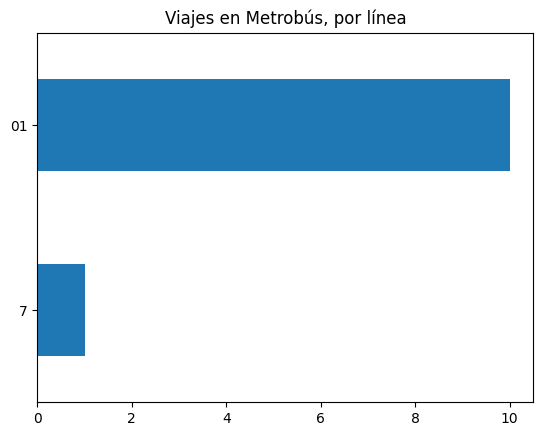

In [23]:
metrobus["linea"].value_counts()[::-1]\
    .plot.barh(title="Viajes en Metrobús, por línea")

<AxesSubplot:title={'center':'Top 10 estaciones de metro más usadas'}>

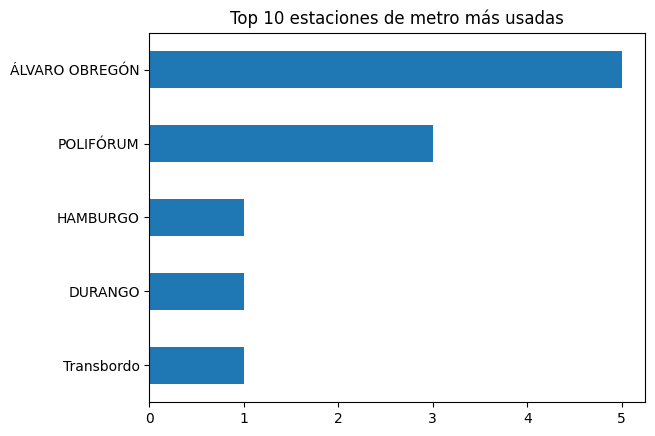

In [24]:
top_n_estaciones = 10
metrobus["estacion"].value_counts()[::-1].head(top_n_estaciones)\
    .rename({"": "Transbordo"}).plot.barh(title=f"Top {top_n_estaciones} estaciones de metro más usadas")

# ECOBICI

In [25]:
ecobici = df.query("organismo=='ECOBICI'")
inicio_viaje = ecobici.query("operacion=='70-INICIO DE VIAJE'")
fin_viaje = ecobici.query("operacion=='71-FIN DE VIAJE'")

In [26]:
#.agg(["min", "mean", "median", "max"])
ecobici.empty

False

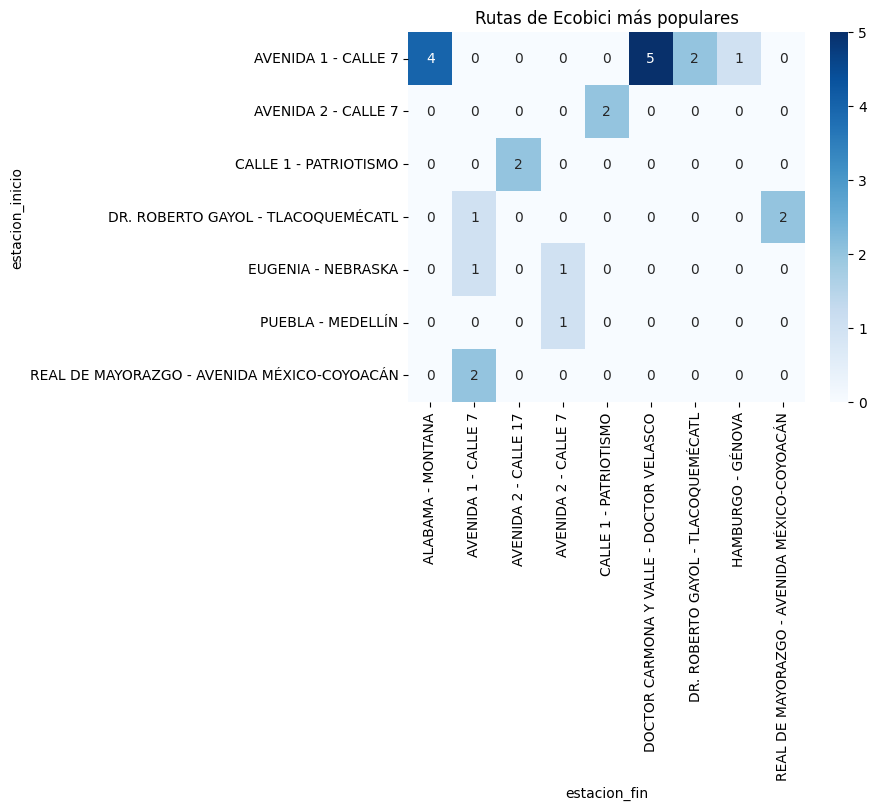

In [27]:
if not ecobici.empty:
    inicio_fin = inicio_viaje.merge(fin_viaje.eval('numero=numero+1'), on='numero', suffixes=("_inicio", "_fin"))\
        .filter(["fecha_inicio", "estacion_inicio", "fecha_fin", "estacion_fin", "dia_semana_inicio"])
    inicio_fin["tiempo_viaje"] = (inicio_fin["fecha_fin"] - inicio_fin["fecha_inicio"]).dt.total_seconds() / 60

    matrix_od = pd.crosstab(inicio_fin["estacion_inicio"], inicio_fin["estacion_fin"], margins=True)
    inicios_populares = matrix_od["All"].loc[lambda x: x > 1].index.drop("All")
    fines_populares = matrix_od.loc["All"].loc[lambda x: x > 1].index.drop("All")
    ax = sns.heatmap(matrix_od.loc[inicios_populares, fines_populares], annot=True, cmap="Blues")
    ax.set_title("Rutas de Ecobici más populares")

In [28]:
inicio_fin["tiempo_viaje"].agg(["min", "mean", "median", "max"])

min        2.833333
mean      17.566071
median    16.708333
max       39.100000
Name: tiempo_viaje, dtype: float64

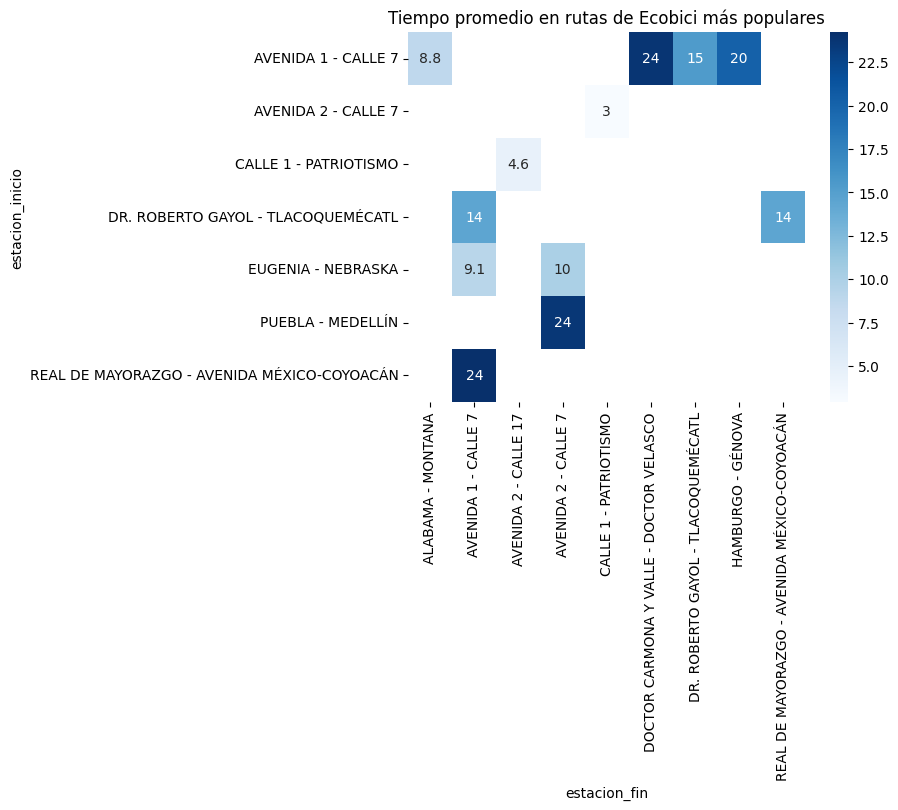

In [29]:
if not ecobici.empty:
    matrix_od_tiempo = pd.crosstab(inicio_fin["estacion_inicio"], inicio_fin["estacion_fin"],
                                   values=inicio_fin["tiempo_viaje"], aggfunc='mean')

    ax = sns.heatmap(matrix_od_tiempo.loc[inicios_populares, fines_populares], annot=True, cmap="Blues")
    ax.set_title("Tiempo promedio en rutas de Ecobici más populares")

In [35]:
import geopandas as gpd
import folium
# Leer el archivo SHP con GeoPandas
path_est_ecobici = 'datos/cicloestaciones_ecobici/cicloestaciones_ecobici.shp'

estaciones_eb = gpd.read_file(path_est_ecobici)
estaciones_eb["estacion"] = (estaciones_eb["calle_prin"] + " - " + estaciones_eb["calle_secu"]).str.upper()
estaciones_eb.to_crs(epsg=4326).to_file("maps/cicloestaciones_ecobici.geojson", driver="GeoJSON")
estaciones_eb.head()

,sistema,num_cicloe,calle_prin,calle_secu,colonia,alcaldia,latitud,longitud,sitio_de_e,estatus,geometry,estacion
0,Ecobici,001,Río Sena,Río Balsas,Cuauhtémoc,Cuauhtémoc,19.433590,-99.167819,Arroyo,Instalada,POINT (-99.16782 19.43359),RÍO SENA - RÍO BALSAS
1,Ecobici,002,Río Guadalquivir,Río Nazas,Cuauhtémoc,Cuauhtémoc,19.430623,-99.171231,Arroyo,Instalada,POINT (-99.17123 19.43062),RÍO GUADALQUIVIR - RÍO NAZAS
2,Ecobici,003,Reforma,Insurgentes,Tabacalera,Cuauhtémoc,19.431630,-99.158547,Banqueta,Instalada,POINT (-99.15855 19.43163),REFORMA - INSURGENTES
3,Ecobici,004,Río Nilo,Río Pánuco,Cuauhtémoc,Cuauhtémoc,19.428491,-99.171693,Arroyo,Instalada,POINT (-99.17169 19.42849),RÍO NILO - RÍO PÁNUCO
4,Ecobici,005,Río Pánuco,Río Tíber,Cuauhtémoc,Cuauhtémoc,19.429804,-99.169451,Arroyo,Instalada,POINT (-99.16945 19.42980),RÍO PÁNUCO - RÍO TÍBER


In [ ]:

m = folium.Map(location=[19.432608, -99.133209], zoom_start=11, tiles='Cartodb Positron',
)
folium.GeoJson(lineas, style_function=lambda feature: feature["properties"]["style"]).add_to(m)


# Añadir las estaciones al mapa
viajes_estaciones = metro.estacion.str.lower().value_counts().to_dict()
for _, row in gdf_est.loc[lambda x: x["NOMBRE"].str.lower().isin(metro["estacion"].str.lower().unique())].iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius= viajes_estaciones[row['NOMBRE'].lower()] / 10,  # Ajustar el factor de escala según sea necesario
        popup=folium.Popup(f"{row['NOMBRE']} - Viajes: {viajes_estaciones[row['NOMBRE'].lower()]}"),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)
m